# Analysis of meteorological driver (PERSIANN-CDR)

PERSIANN-CDR data limited to 1985-2020, analysis and paper Figures (Fig.s 2, 3, 4 Appendix Fig.s C2, C4, C5 )

Also comparison of PERSIANN-CDR data with MSWEP and CHIRPS (Appendix Fig.s C2)

rosa.pietroiusti@vub.be


In [1]:
# in sidebar: import regionmask, Cartopy, netcdf4, statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
%matplotlib inline
import os, glob 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import statsmodels
import statsmodels.api as sm

c:\Users\rpietroi\Anaconda3\envs\spyder_env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
vsc_vo_data = os.environ['VSC_DATA_VO_USER']

# change current working directory to GCM hist simulations
os.chdir(vsc_vo_data)
os.chdir('Thesis/ISIMIP3b/hist') 

# or if you want hist-rcp370 
os.chdir(vsc_vo_data)
os.chdir('Thesis/ISIMIP3b/hist-rcp70') 

# print GCM directory and folders in it 
#inDIR = os.getcwd()
#print(inDIR)
#GCMs = sorted(os.listdir(os.curdir), key=str.casefold) # sort case-insensitive
#print(GCMs)

#observations ncfile
obsDIR = os.path.join(vsc_vo_data, 'Thesis/PERSIANN')
obsFILE = os.path.join(obsDIR, 'PERSIANN-CDR_v01r01_1983_2020_remapped_owngrid_reorder_timelatlon.nc')
if os.path.exists(obsFILE) is False: 
    print('missing observational PERSIANN file!') # check the file exists
    
obsFILE_fill = os.path.join(obsDIR, 'PERSIANN-CDR_v01r01_1983_2020_remapped_owngrid_reorder_timelatlon_fillnan_climato.nc')
if os.path.exists(obsFILE) is False: 
    print('missing observational PERSIANN file!') # check the file exists
    
# Basin shapefile
WBM_path = os.path.join(vsc_vo_data, 'Thesis/WBM-git') 
filepath_shp_basin = os.path.join(WBM_path,'input_data', 'shapefiles', 'Watsub.shp' ) 
basin_shp = gpd.read_file(filepath_shp_basin, crs="epsg:4326")

# observations csv 
obsFILE_tseries_fill = os.path.join(obsDIR, 'PERSIANN_basinlake_daily_ppn_climato_fill_1983_2020.csv')

# IOD data
#iod_path = os.path.join(vsc_vo_data, 'Thesis/IOD/dmi_seasonal_1870_2021.csv') 
#iod_df = pd.read_csv(iod_path, index_col=0)

fig_path = os.path.join(vsc_vo_data, 'Thesis/figures/fig_jun23_cut1985_PERSIANN')

## Functions 

In [3]:
# to check what's going on with my filling stuff
def mask_da(da, shp):
    # mask data to basilake 
    mask = regionmask.mask_geopandas(shp, np.array(da.lon), np.array(da.lat)) + 1
    mask_da = da.where(mask == 1 )
    return mask_da


def fill_climato_spatial(da):
    # fill spatial data with climatology (original script: PERSIANN_fillnan-spatial.py)
    
    # get missing days
    indices = []
    data = da
    for t in data.time:
        if np.isnan(data.sel(time=t).values).all() == True:
            indices.append(t.values)
    print('nan days=', len(indices))
    
    # calc climatology
    climatology_daily = data.groupby("time.dayofyear").mean('time')
    
    # fill nan days
    da_fill = data.copy()
    for i in indices:
        da_fill.loc[dict(time=i)] = climatology_daily[da_fill.sel(time=i).time.dt.dayofyear.values - 1].values
    
    # check if any missing days are left
    check = []
    data = da_fill
    for t in data.time:
        if np.isnan(data.sel(time=t).values).all() == True:
            check.append(t.values)
    print('nan days left =', len(check))
    
    return da_fill



def fill_climato_timeseries(data_daily, varname):
    # fill timeseries (original script: PERSIANN_preciptseries_LVB_analysis-iod.oy)
    
    #calc climatology
    daily_climato = data_daily.groupby(data_daily.index.dayofyear).mean('time')
    
    # find all nans
    badrows = np.isnan(data_daily[varname])
    print('nan days = ', badrows.sum())

    # replace nans with climatology 
    data = data_daily.copy()
    data.loc[badrows,varname] = daily_climato.loc[data.loc[badrows,'doy'].values, varname].values
    data_daily_fill = data.drop(columns=['doy'])
    #data_daily_fill[varname].plot()

    # check how many nans are left 
    badrows = np.isnan(data_daily[varname])
    print('nan days left =', badrows.sum())
    
    return data_daily_fill
    
def summary(da):
    print('min', da.min(), '\nmax', da.max(), '\nmean', da.mean())
    

## Open data

In [4]:
ncfile = obsFILE
var = 'precipitation'

# original persiann file
with xr.open_dataset(ncfile, engine='netcdf4') as ds:
    print(str(list(ds.keys())))
    print(str(list(ds.dims)))
    ds_dims = list(ds.dims) # time,lon, lat
    ds_varnames = list(ds.keys()) # get names of variables precipitation
    time = np.array(ds.get('time'))
    PERSIANN_raw = ds[str(var)] 
    PERSIANN_zero = PERSIANN_raw.where(PERSIANN_raw > 0, 0) # original dataset kept when true, condition, value when false

#ncfile = obsFILE_fill
#var = 'precipitation'

# filled spatially with climatology
#with xr.open_dataset(ncfile, engine='netcdf4') as ds:
#    print(str(list(ds.keys())))
#    print(str(list(ds.dims)))
#    ds_dims = list(ds.dims) # time,lon, lat
#    ds_varnames = list(ds.keys()) # get names of variables precipitation
#    time = np.array(ds.get('time'))
#    PERSIANN_raw_fill = ds[str(var)] 
#    PERSIANN_zero_fill = PERSIANN_raw_fill.where(PERSIANN_raw_fill > 0, 0) # original dataset kept when true, condition, value when false
    
# open filled timeseries to compare
#PERSIANN_tseries_fill = pd.read_csv(obsFILE_tseries_fill, parse_dates=True, index_col=0)

['precipitation']
['time', 'lat', 'lon']


## Cut to 1985-2020

In [13]:
precip_zero_cut = PERSIANN_zero.sel(time=slice("1985-01-01", "2020-12-31"))
precip_zero_cut

<xarray.DataArray 'precipitation' (time: 13149, lat: 130, lon: 130)>
array([[[9.12193775e-01, 4.91303474e-01, 4.91156816e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.04556954e+00, 4.73995298e-01, 4.73969370e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.04474318e+00, 4.73526597e-01, 4.73500639e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [3.37075382e-01, 4.19188827e-01, 4.18851256e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.12481248e-01, 5.52103937e-01, 5.51748157e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.12737548e-01, 5.52303493e-01, 5.51947713e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[2.25576747e-04, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.66951315e-04, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [8.53223622e-01, 1.00914621e+00, 1.00957394e+00, ...,
         1.65605429e-03, 2.87049403e-03, 2.87049403e-03],
        [8.53928506e-01, 1.05205393e+00, 1.05193818e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.54075789e-01, 1.05204892e+00, 1.05193317e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[6.08950186e+00, 6.74718094e+00, 6.74841738e+00, ...,
         1.05901012e+01, 1.09768209e+01, 1.09804535e+01],
        [5.87846231e+00, 6.72436523e+00, 6.72408962e+00, ...,
         8.69487381e+00, 8.98353767e+00, 8.98639870e+00],
        [5.87989950e+00, 6.72695494e+00, 6.72667933e+00, ...,
         8.69531441e+00, 8.98443890e+00, 8.98730087e+00],
        ...,
        [1.17841017e+00, 1.13744116e+00, 1.13881481e+00, ...,
         1.54983463e+01, 1.55483923e+01, 1.55489988e+01],
        [8.77348602e-01, 6.35341823e-01, 6.36683524e-01, ...,
         1.71821556e+01, 1.67750645e+01, 1.67717686e+01],
        [8.77215981e-01, 6.35135114e-01, 6.36476696e-01, ...,
         1.71763554e+01, 1.67737598e+01, 1.67704639e+01]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2020-12-31
  * lat      (lat) float64 -5.5 -5.435 -5.37 -5.305 ... 2.69 2.755 2.82 2.885
  * lon      (lon) float64 28.0 28.07 28.13 28.2 ... 36.19 36.26 36.32 36.38
Attributes:
    standard_name:  precipitation_amount
    long_name:      NOAA Climate Data Record of PERSIANN-CDR daily precipitation
    units:          mm
    cell_method:    sum

## Remake PERSIANN plots and data

## Figure 2 paper - to update

### Functions

In [14]:

def plot_map(ax, data, title, cmap, levels, label, norm=False):
    gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, linewidth=0.8, color='gray', alpha=0.6, linestyle='dotted')
    gl.ylabels_right = False
    gl.xlabels_top = False
    if norm==True:
        plot = ax.contourf(lons, lats, data,  cmap=cmap, norm=mcolors.CenteredNorm(), levels=levels,  transform=ccrs.PlateCarree())
    if norm==False:
        plot = ax.contourf(lons, lats, data,  cmap=cmap, levels=levels,  transform=ccrs.PlateCarree())
    ax.set_title(title, loc = 'left', size=12 )
    ax.coastlines(color='dimgray', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, facecolor="none", edgecolor='black', linewidth=0.8 )
    return plot, cmap

def plot_basin(ax, col):
    basin_shp.boundary.plot(ax=ax, edgecolor=col, linewidth=1.5, label='basin')

/apps/brussel/CO7/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/apps/brussel/CO7/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/apps/brussel/CO7/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/apps/brussel/CO7/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/ca

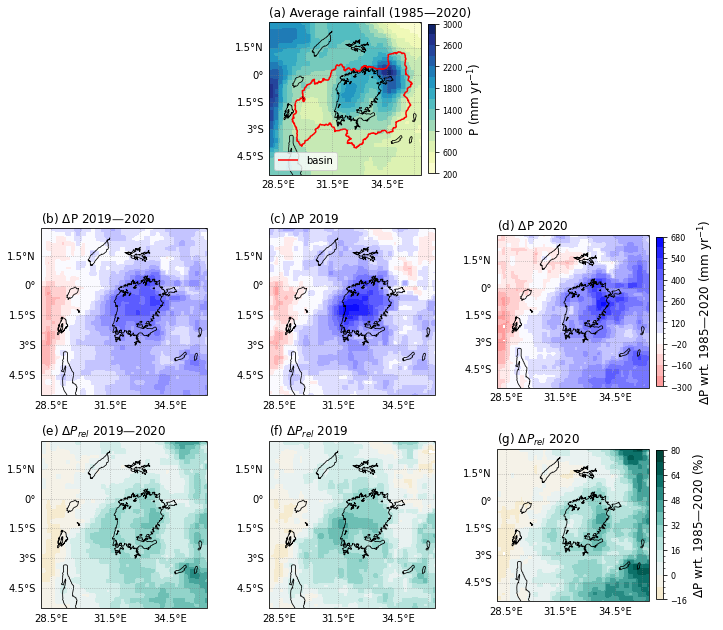

In [15]:
# PLOT AVERAGE PRECIP CLIMATOLOGY AND ABSOLUTE AND RELATIVE ANOMALIES  
#======================================================#
plt.rcParams['figure.figsize'] = [10, 5]

# Set data 
precip_mean_yr =  precip_zero_cut.resample(time='Y', label='right').sum().mean('time')
data1920 = precip_zero_cut.sel(time=slice('{}-01-01'.format(2019), '{}-12-31'.format(2020))).resample(time='Y', label='right').sum().mean('time')
data2019 = precip_zero_cut.sel(time=slice('{}-01-01'.format(2019), '{}-12-31'.format(2019))).resample(time='Y', label='right').sum().mean('time')
data2020 = precip_zero_cut.sel(time=slice('{}-01-01'.format(2020), '{}-12-31'.format(2020))).resample(time='Y', label='right').sum().mean('time')

# Decide if plotting shapefile
flag_shp=0

# Get lat and lon coordinates
lats = data1920['lat']
lons = data1920['lon']

# Amount of plots
rs = 3
cs = 3

# Prepare your data (see above)
climato_start = 1985
climato_end = 2020
anomaly_start, anomaly_end = 2019, 2020

# initiate the figure
f = plt.figure(figsize = (10, 9))

# n.1 : climatology
ax1 = plt.subplot(rs, cs, 2, projection=ccrs.PlateCarree())

# Set data and metadata
data = precip_mean_yr
title = '(a) PERSIANN mean ({}\u2014{})'.format(climato_start, climato_end)
title = '(a) Average rainfall ({}\u2014{})'.format(climato_start, climato_end)
cmap = 'YlGnBu'
levels = 15 
labels = 'P (mm yr$^{-1}$)'


#Plot
plot, cmap = plot_map(ax1, data, title, cmap, levels, labels)
cb = f.colorbar(plot, ax=ax1, fraction= 0.045, pad= 0.04, extend='both')
cb.set_label(label=labels, size=12); cb.ax.tick_params(labelsize=8)

# Plot basin shapefile
if flag_shp == 0 or flag_shp == 1:
    plot_basin(ax1, "red")
    ax1.legend(loc='lower left')

# n. 2 - 3 - 4 : relative anomalies
ax1 = plt.subplot(rs, cs, 4, projection=ccrs.PlateCarree())

# Absolute anomalies 
data0 = ( data1920 - precip_mean_yr ) 
data1 = ( data2019 - precip_mean_yr ) 
data2 = ( data2020 - precip_mean_yr ) # anomaly 2019-2020 vs. 1983-2020

# Set what you are plotting 
datalist = [data0, data1,data2]
subplotslist = ['(b) $\Delta$P {}\u2014{}'.format(2019,2020),
                '(c) $\Delta$P {}'.format('2019'), 
                '(d) $\Delta$P {}'.format('2020')] 
cmaplist = ['bwr_r','bwr_r', 'bwr_r'] 
norm=True

labelslist = ['$\Delta$P (mm yr$^{-1}$)', '$\Delta$P (mmcc)','$\Delta$P wrt. {}\u2014{}'.format(climato_start,climato_end)+' (mm yr$^{-1}$)'] 

levelslist = [np.linspace(-300,680,15), # un colore ogni 10 mm : 10*22 = 220 : 220/10 = 22
              np.linspace(-300,680,15), 
              np.linspace(-300,680,15)]

# Plot
i=0
plot, cmap = plot_map(ax1, datalist[i], subplotslist[i], cmaplist[i], levelslist[i], labelslist[i], norm=norm)

# Plot basin shapefile
if flag_shp == 1:
    plot_basin(ax1, "darkred")

# n.3
ax1 = plt.subplot(rs, cs, 5, projection=ccrs.PlateCarree())
i=1
plot, cmap = plot_map(ax1, datalist[i], subplotslist[i], cmaplist[i], levelslist[i], labelslist[i], norm=norm)

# Plot basin shapefile
if flag_shp == 1:
    plot_basin(ax1, "darkred")
    
# n. 4
ax1 = plt.subplot(rs, cs, 6, projection=ccrs.PlateCarree())
i=2
plot, cmap = plot_map(ax1, datalist[i], subplotslist[i], cmaplist[i], levelslist[i], labelslist[i], norm=norm)

# Plot basin shapefile
if flag_shp == 1:
    plot_basin(ax1, "darkred")
    
cb = f.colorbar(plot, extend='both', fraction= 0.045, pad= 0.04, ax=ax1)  
cb.set_label(label=labelslist[i], size=12); cb.ax.tick_params(labelsize=8)
cb.minorticks_on()

# n. 5 - 6 - 7 : relative anomalies 
ax1 = plt.subplot(rs, cs, 7, projection=ccrs.PlateCarree())

# Set data
data0 = ( data1920 - precip_mean_yr ) / precip_mean_yr * 100
data1 = ( data2019 - precip_mean_yr ) / precip_mean_yr * 100
data2 = ( data2020 - precip_mean_yr ) / precip_mean_yr * 100 # anomaly 2019-2020 vs. 1983-2020


# Set what you are plotting 
datalist = [data0, data1,data2]
subplotslist = ['(e) $\Delta$$P_{rel}$'+' {}\u2014{}'.format(anomaly_start,anomaly_end),
                '(f) $\Delta$$P_{rel}$'+' {}'.format('2019'), 
                '(g) $\Delta$$P_{rel}$'+' {}'.format('2020')] 
cmaplist = ['BrBG','BrBG', 'BrBG'] 
labelslist = ['$\(mm/mo)', '$\DeltaP_{rel}$ (mm/mo)','$\Delta$P wrt. {}-{} (%)'.format(climato_start,climato_end)] 
labelslist = ['$\(mm/mo)', '$\DeltaP_{rel}$ (mm/mo)','$\Delta$P wrt. {}\u2014{} (%)'.format(climato_start,climato_end)] 
levelslist = [np.linspace(-16,80,13), # un colore ogni 10 mm : 10*22 = 220 : 220/10 = 22
              np.linspace(-16,80,13), 
              np.linspace(-16,80,13)] # try to force it to have 11 steps

# Plot
i=0
plot, cmap = plot_map(ax1, datalist[i], subplotslist[i], cmaplist[i], levelslist[i], label=labelslist[i], norm=True)

# n. 5 
ax1 = plt.subplot(rs, cs, 8, projection=ccrs.PlateCarree())
i=1
plot, cmap = plot_map(ax1, datalist[i], subplotslist[i], cmaplist[i], levelslist[i], labelslist[i], norm=True)

# n. 6 
ax1 = plt.subplot(rs, cs, 9, projection=ccrs.PlateCarree())

i=2
plot, cmap = plot_map(ax1, datalist[i], subplotslist[i], cmaplist[i], levelslist[i], labelslist[i], norm=True)

cb = f.colorbar(plot, extend='both', fraction= 0.045, pad= 0.04, ax=ax1)  
cb.set_label(label=labelslist[i], size=12); cb.ax.tick_params(labelsize=8)
cb.minorticks_on()

plt.tight_layout()
#plt.show()

#plt.savefig(os.path.join(fig_path,'PERSIANN_map_climatology19852020_anomaly20192020_year_basin_cut1985.png'),dpi=300)
#plt.savefig(os.path.join(fig_path,'PERSIANN_map_climatology19852020_anomaly20192020_year_basin_cut1985.pdf'),dpi=300)

In [16]:
data0 = ( data1920 - precip_mean_yr )
print('2019-2020 anomaly max mm/yr', data0.max().data)
maxpr = data0.where(data0 == data0.max(), drop=True).squeeze()
maxpr_rel = maxpr.data / precip_mean_yr.loc[maxpr.coords]
print('corresponding to a % increase', maxpr_rel.data)

#%%

data0 = ( data2019 - precip_mean_yr )
print('2019 anomaly max mm/yr', data0.max().data)
maxpr = data0.where(data0 == data0.max(), drop=True).squeeze()
maxpr_rel = maxpr.data / precip_mean_yr.loc[maxpr.coords]
print('corresponding to a % increase', maxpr_rel.data)

#%%

data0 = ( data2019 - precip_mean_yr ) / precip_mean_yr
print('2019 anomaly max % ', data0.max().data)
maxpr = data0.where(data0 == data0.max(), drop=True).squeeze()
maxpr

#%%

data0 = ( data2020 - precip_mean_yr )
print('2020 anomaly max mm/yr', data0.max().data)
maxpr = data0.where(data0 == data0.max(), drop=True).squeeze()
maxpr_rel = maxpr.data / precip_mean_yr.loc[maxpr.coords]
print('corresponding to a % increase', maxpr_rel.data)

2019-2020 anomaly max mm/yr 492.9678955078125
corresponding to a % increase 0.37774098
2019 anomaly max mm/yr 651.6383056640625
corresponding to a % increase 0.40606606
2019 anomaly max %  0.4101342260837555
2020 anomaly max mm/yr 618.490478515625
corresponding to a % increase 0.45764872


### Check old data 

In [17]:
# check with unfilled data (original in paper, incorrect numbers)

# Set data 
precip_mean_yr = PERSIANN_zero.resample(time='Y', label='right').sum().mean('time')
data1920 = PERSIANN_zero.sel(time=slice('{}-01-01'.format(2019), '{}-12-31'.format(2020))).resample(time='Y', label='right').sum().mean('time')
data2019 = PERSIANN_zero.sel(time=slice('{}-01-01'.format(2019), '{}-12-31'.format(2019))).resample(time='Y', label='right').sum().mean('time')
data2020 = PERSIANN_zero.sel(time=slice('{}-01-01'.format(2020), '{}-12-31'.format(2020))).resample(time='Y', label='right').sum().mean('time')

data0 = ( data1920 - precip_mean_yr )
print('2019-2020 anomaly max mm/yr', data0.max().data)
maxpr = data0.where(data0 == data0.max(), drop=True).squeeze()
maxpr_rel = maxpr.data / precip_mean_yr.loc[maxpr.coords]
print('corresponding to a % increase', maxpr_rel.data)

#%%

data0 = ( data2019 - precip_mean_yr )
print('2019 anomaly max mm/yr', data0.max().data)
maxpr = data0.where(data0 == data0.max(), drop=True).squeeze()
maxpr_rel = maxpr.data / precip_mean_yr.loc[maxpr.coords]
print('corresponding to a % increase', maxpr_rel.data)

#%%

data0 = ( data2019 - precip_mean_yr ) / precip_mean_yr
print('2019 anomaly max % ', data0.max().data)
maxpr = data0.where(data0 == data0.max(), drop=True).squeeze()
maxpr

#%%

data0 = ( data2020 - precip_mean_yr )
print('2020 anomaly max mm/yr', data0.max().data)
maxpr = data0.where(data0 == data0.max(), drop=True).squeeze()
maxpr_rel = maxpr.data / precip_mean_yr.loc[maxpr.coords]
print('corresponding to a % increase', maxpr_rel.data)

2019-2020 anomaly max mm/yr 515.3814697265625
corresponding to a % increase 0.40181664
2019 anomaly max mm/yr 660.491455078125
corresponding to a % increase 0.35276407
2019 anomaly max %  0.42443200945854187
2020 anomaly max mm/yr 639.6209716796875
corresponding to a % increase 0.48080164


## Figure 3 paper - ok

OND anomaly 2019             precipitation
time                     
2019-12-31     248.610687
JF anomaly 2020             precipitation
time                     
2020-12-31     114.712173
MAM anomaly 2020             precipitation
time                     
2020-12-31      92.130371


/tmp/ipykernel_21136/1746612892.py:104: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


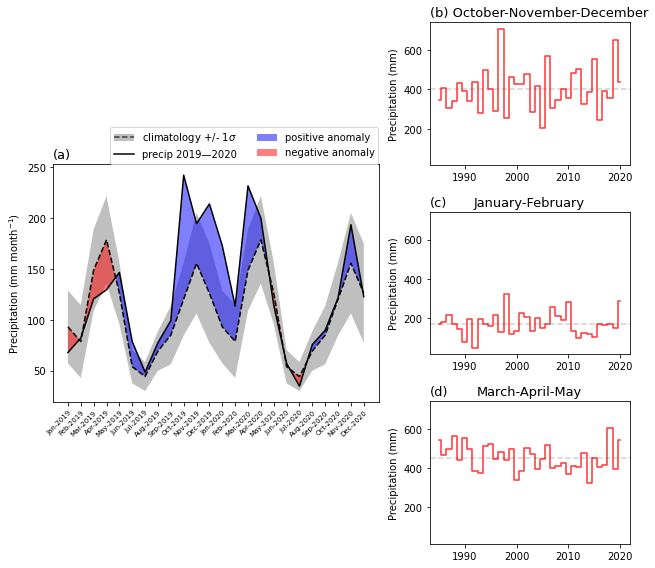

In [18]:

#===========#
# EXTRACT OND, JF, MAM
#===========#

# data 
precip_monthly_df = mask_da(precip_zero_cut, basin_shp).mean(dim=['lat','lon']).resample(time='M', label='right').sum().to_dataframe()

climato_df = precip_monthly_df.groupby(precip_monthly_df.index.month).mean('time')
climato_sd = precip_monthly_df.groupby(precip_monthly_df.index.month).std()['precipitation']

lower = climato_df['precipitation'] - climato_sd
upper = climato_df['precipitation'] + climato_sd

precip_1920 = precip_monthly_df['2019-01-01':'2020-12-31']
precip_1920_df = precip_1920.reset_index(drop=True)

climato_2yrs = pd.concat([climato_df, climato_df], axis=0).reset_index(drop=True)
lower_2yrs = pd.concat([lower,lower], axis=0).reset_index(drop=True)
upper_2yrs = pd.concat([upper,upper], axis=0).reset_index(drop=True)

time = precip_1920.index.strftime('%b-%Y').values

# OND
precip_monthly_OND = precip_monthly_df[precip_monthly_df.index.month > 9]
precip_yearly_OND = precip_monthly_OND.resample('Y', label='right').sum()
print('OND anomaly 2019', precip_yearly_OND.loc['2019'] - precip_yearly_OND.mean())

# JF
precip_monthly_JF = precip_monthly_df[precip_monthly_df.index.month < 3]
precip_yearly_JF = precip_monthly_JF.resample('Y', label='right').sum()
print('JF anomaly 2020', precip_yearly_JF.loc['2020'] - precip_yearly_JF.mean())

#MAM
precip_monthly_MAM = precip_monthly_df[(precip_monthly_df.index.month >2) & (precip_monthly_df.index.month < 6)]
precip_yearly_MAM = precip_monthly_MAM.resample('Y', label='right').sum()
print('MAM anomaly 2020', precip_yearly_MAM.loc['2020'] - precip_yearly_MAM.mean())


#===========#
# PLOT TOGETHER CLIMATO v. MONTHLY AND OND, JF, MAM TIMESERIES
# ADJUST WIDTH
#===========#

fig = plt.figure( figsize = (9, 8), layout="constrained") 

ax = plt.subplot2grid((12, 5), (3, 0), colspan=3, rowspan=6)

which_ticks = range(24)

dashed, = ax.plot(climato_2yrs['precipitation'],  c='0', ls='--') #label='climatology',
fill = ax.fill_between(range(24), lower_2yrs, upper_2yrs, color='gray', alpha=0.5, 
                       label='climatology 1$\sigma$', edgecolor='none')

full, = ax.plot(precip_1920_df['precipitation'], label='precip 2019\u20142020', c='black')


fillu = ax.fill_between(range(24), climato_2yrs['precipitation'], precip_1920_df['precipitation'], where=(climato_2yrs['precipitation'] <= precip_1920_df['precipitation']), 
                color='blue', alpha=0.5,
                 interpolate=True, label='positive anomaly', edgecolor='none')
filll = ax.fill_between(range(24), climato_2yrs['precipitation'], precip_1920_df['precipitation'], where=(climato_2yrs['precipitation'] > precip_1920_df['precipitation']), 
                color='red', alpha=0.5,
                 interpolate=True, label='negative anomaly', edgecolor='none')

ax.set_xticks(which_ticks)
ax.set_xticklabels(time[which_ticks], size=7)
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')


lgnd = ax.legend([(dashed,fill), full, fillu, filll], 
                 ["climatology +/- 1$\sigma$", 'precip 2019\u20142020', 
                  'positive anomaly', 'negative anomaly'],
                 bbox_to_anchor=(1.015, 1.18),  loc='upper right', prop={'size': 10}, 
                 ncol=2) #bbox_to_anchor=(1.015, 1.28), loc='upper right', 


ax.set_ylabel("Precipitation (mm month$^{-1}$)")
ax.set_title('(a)', loc = 'left', size=13 )


ax1 = plt.subplot2grid((12, 5), (0, 3), colspan=2, rowspan=4)

ax1.set_title('(b) October-November-December', loc ='left', size=13 )
ax1.axhline(precip_yearly_OND.precipitation.mean(), ls='--', c='lightgray')
ax1.step(precip_yearly_OND.index.year, precip_yearly_OND.precipitation, where='mid', c='red', alpha=0.8)
ax1.set_ylabel("Precipitation (mm)")

ax2 = plt.subplot2grid((12, 5), (4, 3), colspan=2, rowspan=4, sharey = ax1)

ax2.set_title('(c)', loc = 'left', size=13 )
ax2.axhline(precip_yearly_JF.precipitation.mean(), ls='--', c='lightgray')
ax2.step(precip_yearly_JF.index.year, precip_yearly_JF.precipitation, where='mid', c='red', alpha=0.8)
ax2.set_title('January-February', size=13)
ax2.set_ylabel("Precipitation (mm)")

ax3 = plt.subplot2grid((12, 5), (8, 3), colspan=2, rowspan=4, sharey = ax1)

ax3.set_title('(d)', loc = 'left', size=13 )
ax3.axhline(precip_yearly_MAM.precipitation.mean(), ls='--', c='lightgray')
ax3.step(precip_yearly_MAM.index.year, precip_yearly_MAM.precipitation, where='mid', c='red', alpha=0.8)
ax3.set_title('March-April-May', size=13)
ax3.set_ylabel("Precipitation (mm)")

fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'precip_anomaly_seasons_LVB_cut_1985.png'),dpi=300)
#plt.savefig(os.path.join(fig_path,'precip_anomaly_seasons_LVB_cut_1985.pdf'),dpi=300)


In [19]:
precip_yearly_OND.sort_values(var, ascending=False).head()

,precipitation
time,
1997-12-31,708.976624
2019-12-31,650.722900
2006-12-31,572.337646
2015-12-31,557.639038
2012-12-31,505.991028


In [20]:
precip_yearly_JF.sort_values(var, ascending=False).head()

,precipitation
time,
1998-12-31,323.751556
2020-12-31,286.502991
2010-12-31,283.149567
2007-12-31,256.884033
2001-12-31,226.377991


In [21]:
precip_yearly_MAM.sort_values(var, ascending=False).head(10)

,precipitation
time,
2018-12-31,603.828552
1988-12-31,563.352661
1990-12-31,553.557251
2020-12-31,545.964722
1985-12-31,543.957825
1995-12-31,523.732910
2006-12-31,516.751099
1994-12-31,510.552246
2002-12-31,505.140564


## Figure 4 paper - to update

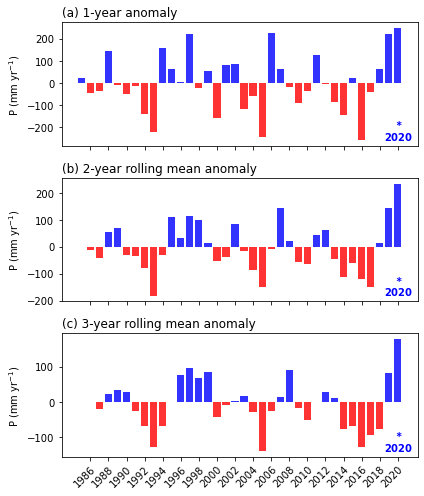

In [22]:
# set data - precipitation basinlake, first spatial mean each day then resample to year
anomaly_yearly_df = mask_da(precip_zero_cut, basin_shp).mean(dim=['lat','lon']).resample(time='Y', label='right').sum()
anomaly_yearly_df = (anomaly_yearly_df - anomaly_yearly_df.mean()).to_dataframe()

# data
var = 'precipitation'

which_ticks = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34] 
which_ticks = (np.array(which_ticks) + 1).tolist()
years = anomaly_yearly_df.index.year

window_list = [1,2,3]

rows=1
cols=3
figsize = (6,7)

subplotslist = ['(a) ', '(b) ', '(c) ']

fig, axes2d = plt.subplots(nrows=cols, ncols=rows,figsize=figsize,  sharex=True ) #

if (rows+cols) > 1:
    axes2d = axes2d.flatten()
    
for win,ax, sub in zip(window_list, enumerate(axes2d), subplotslist):
    ax = ax[1]

    anomaly_yearly_roll = anomaly_yearly_df.rolling(win, center=False).mean() # label set to right
    colors = ["red" if i < 0 else "blue" for i in anomaly_yearly_roll[var]]

    ax.bar(range(len(anomaly_yearly_roll.index)), anomaly_yearly_roll[var], color=colors, alpha=0.8)
    
    # Labels 
    #ax.set_ylabel("$\Delta$P (mm/yr)")
    ax.set_ylabel("Precipitation (mm/yr)")
    ax.set_ylabel("Precipitation (mm yr$^{-1}$)")
    ax.set_ylabel("P (mm yr$^{-1}$)")
    ax.set_xticks(which_ticks)
    ax.set_xticklabels(years[which_ticks])
    # Title 
    if win == 1 :
        ax.set_title('{}{}-year anomaly'.format(sub, win), loc = 'left', size=12 )
    else:  
        ax.set_title('{}{}-year rolling mean anomaly'.format(sub, win), loc = 'left', size=12 )
    # Asterisk on record-breaking
    max_precip = anomaly_yearly_roll[anomaly_yearly_roll[var] == anomaly_yearly_roll[var].max()]
    max_year = int(max_precip.index.year.values)
    max_index = list(years).index(max_year)
    #max_year = years[max_precip.index][0]
    ax.annotate(' *\n{}'.format(max_year), (max_index, anomaly_yearly_roll[var].min()), ha='center', c='blue', weight='bold')

    
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')
fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'precip_anomaly_yearly_roll_123yr_LVB_cut1985.png'),dpi=300)
#plt.savefig(os.path.join(fig_path,'precip_anomaly_yearly_roll_123yr_LVB_cut1985.pdf'),dpi=300)



In [23]:
anomaly_yearly_df.sort_values(var, ascending=False).head() # 2020 ranks second wettest after 1988

,precipitation
time,
2020-12-31,247.678467
2006-12-31,224.459595
1997-12-31,221.764893
2019-12-31,221.302490
1994-12-31,157.152344


In [24]:
win = 2
anomaly_yearly_df.rolling(win, center=False).mean().sort_values(var, ascending=False).head() #2019-2020 wettest two-year period

,precipitation
time,
2020-12-31,234.490479
2007-12-31,143.648438
2019-12-31,142.788513
1997-12-31,112.756470
1995-12-31,110.347900


## Supplementary figures: trend in precipitation

### Functions

In [25]:
# Functions

def fit_trend(data, var):
    x=range(len((data.index)))
    y=data[var]
    fit=sm.OLS(y, sm.add_constant(x)).fit()    
    return fit, x, y

def f_test(fit):
    print('F test - F value:', fit.fvalue, 'p-value', fit.f_pvalue)

In [26]:
# data and trend fitting 
var = 'precipitation'
precip_monthly_df = mask_da(precip_zero_cut, basin_shp).mean(dim=['lat','lon']).resample(time='M', label='right').sum().to_dataframe()

# Yearly 
precip_yearly_df = mask_da(precip_zero_cut, basin_shp).mean(dim=['lon','lat']).resample(time='Y', label='right').sum().to_dataframe()
fit0, x0, y0 = fit_trend(precip_yearly_df, var)
    
# OND
precip_yearly_OND = precip_monthly_df[precip_monthly_df.index.month > 9].resample('Y', label='right').sum()
fit1, x1, y1 = fit_trend(precip_yearly_OND, var)

# JF
precip_yearly_JF = precip_monthly_df[precip_monthly_df.index.month < 3].resample('Y', label='right').sum()
fit2, x2, y2 = fit_trend(precip_yearly_JF, var)

#MAM
precip_yearly_MAM = precip_monthly_df[(precip_monthly_df.index.month >2) & (precip_monthly_df.index.month < 6)].resample('Y', label='right').sum()
fit3, x3, y3 = fit_trend(precip_yearly_MAM, var)

#JJAS
precip_yearly_JJAS = precip_monthly_df[(precip_monthly_df.index.month >5) & (precip_monthly_df.index.month < 10)].resample('Y', label='right').sum()
fit4, x4, y4 = fit_trend(precip_yearly_JJAS, var)


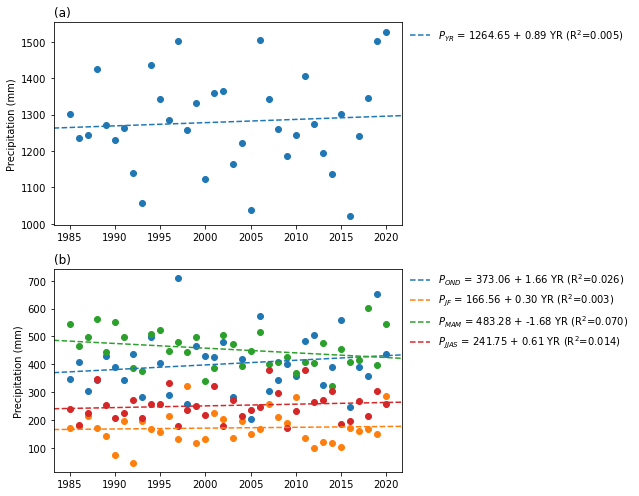

In [27]:
#%% Linear regression for each seasonal accumulation



# Amount of plots
rs = 2
cs = 1

# initiate the figure
fig = plt.figure(figsize=(9,7)) #

ax = plt.subplot(rs, cs, 1)

plt.scatter(x0, y0)
plt.axline([0, fit0.params[0]], slope=fit0.params[1], ls='--', label="$P_{}$ = {:.2f} + {:.2f} YR (R$^2$={:.3f})".format('{YR}',fit0.params[0], fit0.params[1], fit0.rsquared))

ax.set_title('(a)', loc='left')
ax.legend(loc=(1.01,.88),frameon=False)
ax.set_ylabel('Precipitation (mm)')
ax.set_xticks(range(0,38,5), range(1985, 1985+len(range(38)),5))

ax = plt.subplot(rs, cs, 2)

ax.scatter(x1, y1)
ax.axline([0, fit1.params[0]], slope=fit1.params[1], ls='--', label="$P_{}$ = {:.2f} + {:.2f} YR (R$^2$={:.3f})".format('{OND}',fit1.params[0], fit1.params[1], fit1.rsquared), c='C0')

ax.scatter(x2, y2)
ax.axline([0, fit2.params[0]], slope=fit2.params[1], ls='--', label="$P_{}$ = {:.2f} + {:.2f} YR (R$^2$={:.3f})".format('{JF}',fit2.params[0], fit2.params[1], fit2.rsquared), c='C1')

ax.scatter(x3, y3)
ax.axline([0, fit3.params[0]], slope=fit3.params[1], ls='--', label="$P_{}$ = {:.2f} + {:.2f} YR (R$^2$={:.3f})".format('{MAM}',fit3.params[0], fit3.params[1], fit3.rsquared), c='C2')

ax.scatter(x4, y4)
ax.axline([0, fit4.params[0]], slope=fit4.params[1], ls='--', label="$P_{}$ = {:.2f} + {:.2f} YR (R$^2$={:.3f})".format('{JJAS}',fit4.params[0], fit4.params[1], fit4.rsquared), c='C3')

ax.set_title('(b)', loc='left')
ax.legend(loc=(1.01,.58),frameon=False)
ax.set_ylabel('Precipitation (mm)')
ax.set_xticks(range(0,38,5), range(1985, 1985+len(range(38)),5))
#ax.set_xlabel('Years')

#plt.title('seasonal precip basinlake')

fig.tight_layout()

#plt.show()

#plt.savefig(os.path.join(fig_path,'PERSIANN_tseries_linreg_1983_2021_cut1985.pdf'),dpi=300)
#plt.savefig(os.path.join(fig_path,'PERSIANN_tseries_linreg_1983_2021_cut1985.png'),dpi=300)

# used to be in PERSIANN_anomalytseries_LVB_analysis

In [28]:
print('year')
f_test(fit0)
print('OND')
f_test(fit1)
print('JF')
f_test(fit2)
print('MAM')
f_test(fit3)
print('JJAS')
f_test(fit4)

# P value f test on slope

year
F test - F value: 0.17916722349825565 p-value 0.6747554868193075
OND
F test - F value: 0.892950604715443 p-value 0.3513463449284906
JF
F test - F value: 0.10050485122052374 p-value 0.7531631880576782
MAM
F test - F value: 2.572483739567808 p-value 0.11798731150402282
JJAS
F test - F value: 0.48986749165062693 p-value 0.4887479949489665


In [29]:
print('year', fit0.pvalues[1])

print('OND', fit1.pvalues[1])

print('JF', fit2.pvalues[1])

print('MAM', fit3.pvalues[1])

print('JJAS', fit4.pvalues[1])

# p value T test on slope, the same as F test if only one explanatory variable

year 0.6747554958449796
OND 0.35134626716747974
JF 0.7531637840902298
MAM 0.11798730429797968
JJAS 0.4887478589379224


## Supplementary figure: missing nan days

### Functions

In [88]:
def find_nan(da):
    indices = []
    data = da
    for t in data.time:
        if np.isnan(data.sel(time=t).values).all() == True:
            indices.append(t.values)
        
    return pd.DatetimeIndex(indices) 

def make_month_xaxis_labels_ticks():
    startdate = np.datetime64('2000-01-01')
    enddate = np.datetime64('2000-12-31')
    alldays = pd.date_range(start=startdate,end=enddate)

    list_ticks = np.zeros(12)
    for i in range(1,13):
        sel = alldays[alldays.month == i].dayofyear[0] -1
        list_ticks[i-1] = sel

    list_monthnames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    return list_ticks, list_monthnames

def count_daysperyear(dlist):
    years = np.unique(dlist.year)
    df_out = pd.DataFrame({'year': years, 'ndays': np.zeros(len(years))}).set_index('year')

    for year in years:
        slice_days = dlist[dlist.year == year]
        ndays = len(slice_days)
        df_out.loc[year] = ndays
    
    return df_out
    
def count_dayspermonth(dlist):
    months = range(1,13)
    df_out = pd.DataFrame({'month': months, 'ndays': np.zeros(len(months))}).set_index('month')
    
    for i in months:
        slice_days = dlist[dlist.month == i]
        ndays = len(slice_days)
        df_out.loc[i] = ndays
        
    return df_out

In [83]:
nan_days = find_nan(PERSIANN_raw) # in PERSIANN_zero these are set to zero ! The WBM also does this
nan_days

DatetimeIndex(['1983-01-05', '1983-01-06', '1983-01-07', '1983-01-08',
               '1983-01-09', '1983-01-27', '1983-02-15', '1983-04-08',
               '1983-11-12', '1983-11-13',
               ...
               '2008-04-24', '2008-04-25', '2008-12-04', '2009-02-23',
               '2010-09-28', '2011-12-13', '2012-11-27', '2012-11-28',
               '2012-11-29', '2014-12-01'],
              dtype='datetime64[ns]', length=419, freq=None)

In [84]:
df_ndays = count_daysperyear(nan_days)
df_ndays

,ndays
year,
1983,10.0
1984,127.0
1985,19.0
1986,39.0
1987,21.0
1988,30.0
1989,35.0
1990,34.0
1991,5.0


In [89]:
df_ndays_month = count_dayspermonth(nan_days)
df_ndays_month

,ndays
month,
1,34.0
2,116.0
3,17.0
4,29.0
5,43.0
6,50.0
7,17.0
8,21.0
9,18.0


In [ ]:
list_ticks, list_monthnames = make_month_xaxis_labels_ticks()

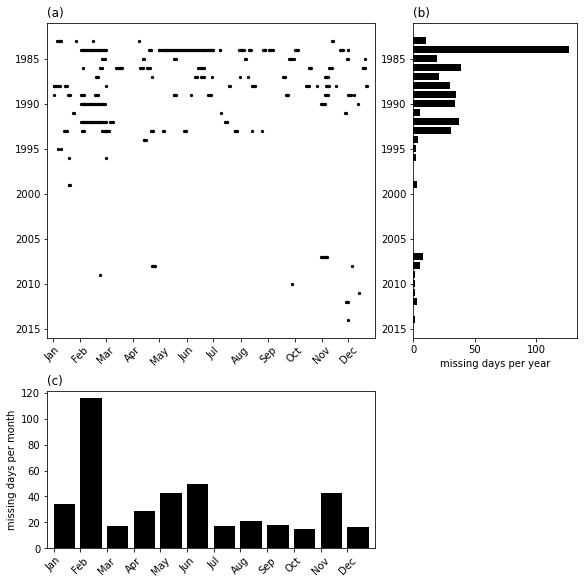

In [208]:
fig = plt.figure( figsize = (8, 8), layout="constrained") 


# scatterplot days each year
ax1 = plt.subplot2grid((6, 3), (0, 0), colspan=2, rowspan=4)
ax1.scatter(nan_days.dayofyear, nan_days.year, s=5, c='k')

# labels
ax1.set_xlim(-6,365)
ax1.set_xticks(list_ticks, list_monthnames, rotation = 45)
ax1.invert_yaxis()
ax1.set_title('(a)', loc='left')

# number of days per year
ax2 = plt.subplot2grid((6, 3), (0, 2), colspan=1, rowspan=4, sharey = ax1)
ax2.barh(df_ndays.index, df_ndays.ndays, color='k')
ax2.set_xlabel('missing days per year')
ax2.set_title('(b)', loc='left')

# number of days per month
ax3 = plt.subplot2grid((6, 3), (4, 0), colspan=2, rowspan=4)
ax3.bar(df_ndays_month.index, df_ndays_month.ndays, color = 'k', align='edge') # 
ax3.set_xticks(range(1,13), list_monthnames, rotation = 45)
#ax3.set_xticks(np.arange(1.5, 13.5, 1), list_monthnames, rotation = 45)
ax3.margins(x=0.02)
ax3.set_ylabel('missing days per month')
ax3.set_title('(c)', loc='left')

#plt.savefig(os.path.join(fig_path,'PERSIANN_nandays.pdf'),dpi=300)
#plt.savefig(os.path.join(fig_path,'PERSIANN_nandays.png'),dpi=300)


In [209]:
fig_path

'/data/brussel/vo/000/bvo00012/vsc10419/Thesis/figures/fig_jun23_cut1985_PERSIANN'